In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn as sns

sns.set(style='ticks', font_scale=1.5)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

In [2]:
if not os.path.exists('../figures'):
    os.makedirs('../figures')

In [3]:
P = np.load('../data/P.npy')
traj = np.load('../data/traj.npy')
goal = np.load('../data/goal.npy')
r_glbs = np.load('../outputs/r_glbs.npy')
a_est = np.load('../outputs/a_est.npy')

num_states = P.shape[0]
gridsize = int(np.sqrt(num_states))
num_actions = P.shape[-1]
num_demo = traj.shape[0]
bkps = [0] + list(np.where(np.diff(goal))[0] + 1) + [num_demo]
markers = ['o', '>', '<', '^', 'v']

ghats = []
for r_idx, r in enumerate(r_glbs):
    ghats += [np.argmax(r) for _ in range(bkps[r_idx + 1] - bkps[r_idx])]
ghats = np.array(ghats)

dist_r = []
for t_idx, (s, a, ns) in enumerate(traj):
    gx, gy = goal[t_idx] // gridsize, goal[t_idx] % gridsize
    ghx, ghy = ghats[t_idx] // gridsize, ghats[t_idx] % gridsize
    dist_r.append(np.abs(gx - ghx) + np.abs(gy - ghy))

errs = np.where(traj[:, 1] != a_est)[0]

In [4]:
frac = np.mean(traj[:, 1] == a_est)
print(f'fraction of action matching: {frac:.2f}')

fraction of action matching: 0.94


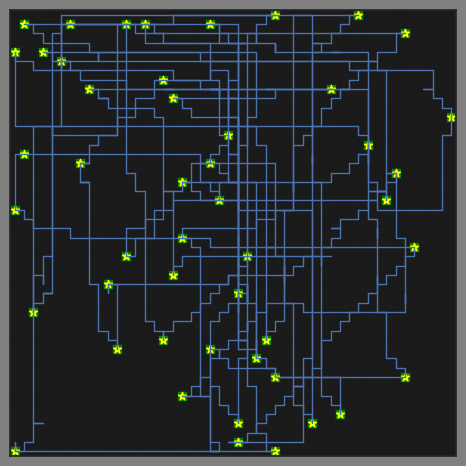

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hlines(np.arange(gridsize) + 0.5, 0 - 0.5, gridsize - 0.5, linewidth=0.1, color='w', alpha=0.1)
axs.vlines(np.arange(gridsize) + 0.5, 0 - 0.5, gridsize - 0.5, linewidth=0.1, color='w', alpha=0.1)
axs.set_xlim(0 - 0.5, gridsize - 0.5)
axs.set_ylim(0 - 0.5, gridsize - 0.5)
axs.set_xticks([])
axs.set_yticks([])
axs.set_facecolor('k')

for t, (s, a, ns) in enumerate(traj):
    x, y = s // gridsize, s % gridsize
    nx, ny = ns // gridsize, ns % gridsize
    axs.plot((x, nx), (y, ny), color='b', linewidth=1)
    # if t == 0:
    #     axs.scatter(x, y, color='r', marker='o')

ugoals = goal[np.hstack((0, np.where(np.diff(goal) != 0)[0] + 1))]
ughats = ghats[np.hstack((0, np.where(np.diff(ghats) != 0)[0] + 1))]
for g_idx, (g, ghat) in enumerate(zip(ugoals, ughats)):
    gx, gy = g // gridsize, g % gridsize
    axs.scatter(gx, gy, color='green', marker='s')
    ghx, ghy = ghat // gridsize, ghat % gridsize
    axs.scatter(ghx, ghy, color='yellow', marker=f'*')

fig.set_facecolor('gray')
plt.tight_layout()
fig.savefig('../figures/sn_goals.pdf', bbox_inches='tight')

In [6]:
solve_times = np.load('../outputs/solve_times.npy')
print(f'solve time: {np.mean(solve_times)} pm {np.std(solve_times) / np.sqrt(len(solve_times))}')
print(f'total: {np.sum(solve_times)}')

solve time: 0.009137873229166666 pm 0.0011621243927325028
total: 0.43861791499999997


In [7]:
# generate video
fig_dir = '../figures/traj'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for t_idx, (s, a, ns) in enumerate(traj):
    ts = ['0' for _ in range(5 - len(str(t_idx)))] + list(str(t_idx))
    ts = ''.join(ts)

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.hlines(np.arange(gridsize) + 0.5, 0 - 0.5, gridsize - 0.5, linewidth=0.1, color='w')
    axs.vlines(np.arange(gridsize) + 0.5, 0 - 0.5, gridsize - 0.5, linewidth=0.1, color='w')
    axs.set_xlim(0 - 0.5, gridsize - 0.5)
    axs.set_ylim(0 - 0.5, gridsize - 0.5)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_facecolor('k')

    x, y = s // gridsize, s % gridsize
    axs.scatter(x, y, color='red', marker=markers[a])
    gx, gy = goal[t_idx] // gridsize, goal[t_idx] % gridsize
    axs.scatter(gx, gy, color='green', marker='s')
    ghx, ghy = ghats[t_idx] // gridsize, ghats[t_idx] % gridsize
    axs.scatter(ghx, ghy, color='yellow', marker='*')
    
    plt.tight_layout()
    fig.set_facecolor('gray')
    fig.savefig(os.path.join(fig_dir, f'{ts}.png'), dpi=200, bbox_inches='tight')
    plt.close(fig)

In [8]:
!ffmpeg -framerate 30 -pattern_type glob -i '../figures/traj/*.png' -c:v libx264 -pix_fmt yuv420p ../figures/traj.mp4

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena